# Projet : Analyse Exploratoire des Données Économiques Mondiales

## Objectif : Analyser les indicateurs économiques mondiaux pour identifier des tendances et des corrélations.

Ce projet analyse les données économiques mondiales pour comprendre les relations entre différents indicateurs tels que le PIB, la dette publique, et les dépenses en éducation. L'objectif est de trouver des corrélations et de visualiser les différences régionales.

In [55]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [21]:
files = [
    "richest_countries.csv",
    "cost_of_living.csv",
    "corruption.csv",
    "tourism.csv",
    "unemployment.csv"
]

base_url = "https://raw.githubusercontent.com/srash007/projet-eda-richesse-vs-cout-de-la-vie/refs/heads/main/Datasets/"
# Charger chaque fichier dans un dictionnaire
dataframes = {}
for file in files:
    url = base_url + file
    df = pd.read_csv(url)
    dataframes[file] = df
    print(f"Chargé : {file} - {df.shape}")

# Aperçu du premier DataFrame
print(dataframes["richest_countries.csv"].head())


Chargé : richest_countries.csv - (50, 2)
Chargé : cost_of_living.csv - (107, 4)
Chargé : corruption.csv - (110, 3)
Chargé : tourism.csv - (41, 5)
Chargé : unemployment.csv - (64, 2)
      country  gdp_per_capita
0  Luxembourg          134754
1   Singapore          116486
2     Ireland          106456
3       Qatar           93521
4     Bermuda           85192


## 1. Étude Comparative des Pays Riches
Analyser si les pays les plus riches sont aussi ceux où le coût de la vie est le plus élevé.

In [22]:
richest_df = dataframes["richest_countries.csv"]
cost_df = dataframes["cost_of_living.csv"]
print("Richest Countries:")
print(richest_df.head())
print("\nCost of Living:")
print(cost_df.head())


Richest Countries:
      country  gdp_per_capita
0  Luxembourg          134754
1   Singapore          116486
2     Ireland          106456
3       Qatar           93521
4     Bermuda           85192

Cost of Living:
          country  cost_index  monthly_income  purchasing_power_index
0         Bermuda       157.6            9712                   105.0
1     Switzerland       142.4            7530                    90.1
2  Cayman Islands       137.9            5281                    65.2
3          Israel       130.2            4130                    54.1
4         Iceland       128.0            5368                    71.5


In [23]:
# Nettoyage des données
richest_df = richest_df.dropna().drop_duplicates()
cost_df = cost_df.dropna().drop_duplicates()


print("\nColonnes - Richest Countries:")
print(richest_df.columns)
print("\nColonnes - Cost of Living:")
print(cost_df.columns)

# Vérification de la cohérence des noms de pays
print("\nPays non communs :")
print(set(richest_df['country']) - set(cost_df['country']))



Colonnes - Richest Countries:
Index(['country', 'gdp_per_capita'], dtype='object')

Colonnes - Cost of Living:
Index(['country', 'cost_index', 'monthly_income', 'purchasing_power_index'], dtype='object')

Pays non communs :
{'Oman', 'Panama', 'Cyprus', 'Slovenia', 'Slovakia', 'Lithuania', 'Bahamas', 'Latvia'}


On constate que le Panama, la Lithuania, la Slovakie, le Latvia, la Chypre, les Bahamas, la Slovenie et le Oman font partis soient des pays les plus riches soient ceux avec le cout de la vie le plus élevé.

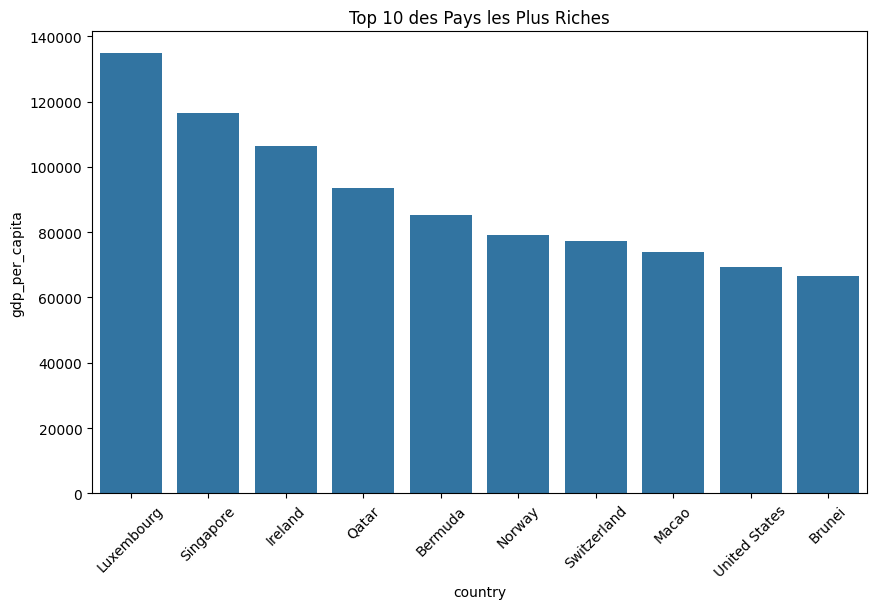

In [24]:
# Tri par PIB par habitant
top10_richest = richest_df.nlargest(10, 'gdp_per_capita')


plt.figure(figsize=(10, 6))
sns.barplot(data=top10_richest, x='country', y='gdp_per_capita')
plt.title('Top 10 des Pays les Plus Riches')
plt.xticks(rotation=45)
plt.show()


Le pays avec le PIB par habitant le plus élevé est le Luxembourg, suivi par Singapour et Irlande.

Les pays du top 10 sont principalement des petites économies développées avec des secteurs financiers puissants ou des ressources naturelles abondantes (comme le Qatar).

Les États-Unis apparaissent dans la liste mais ne sont pas dans le top 5.

Les paradis fiscaux (comme Bermuda et Singapour) contribuent également à ce classement.

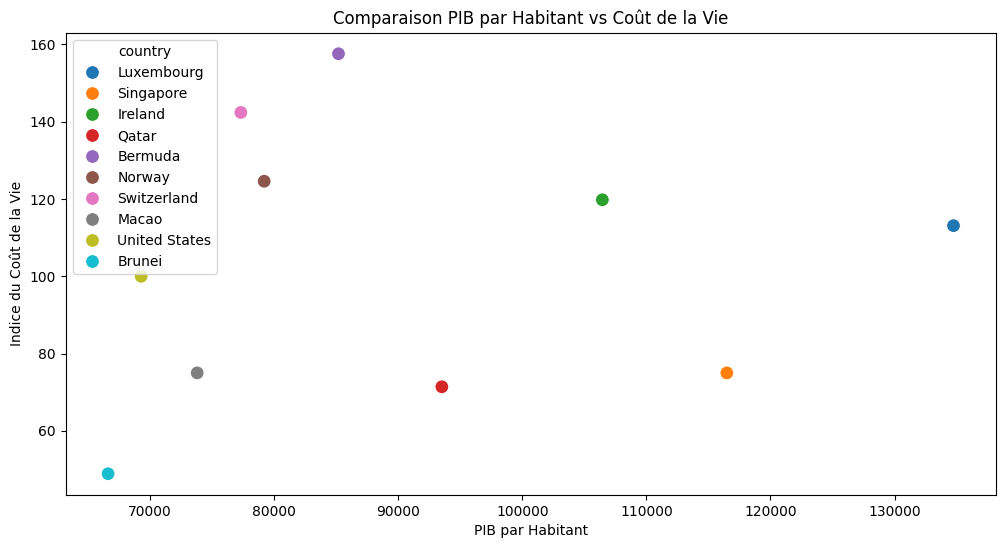

In [25]:

merged_df = pd.merge(richest_df, cost_df, on='country')

top10_merged = merged_df.nlargest(10, 'gdp_per_capita')

# Visualisation comparative
plt.figure(figsize=(12, 6))
sns.scatterplot(data=top10_merged, x='gdp_per_capita', y='cost_index', hue='country', s=100)
plt.title("Comparaison PIB par Habitant vs Coût de la Vie")
plt.xlabel("PIB par Habitant")
plt.ylabel("Indice du Coût de la Vie")
plt.show()


Il n'y a pas de corrélation directe entre la richesse (PIB par habitant) et le coût de la vie parmi ces pays. On a l'exemple de l'Irlande qui a un PIB élevé mais un coût de la vie relativement bas par rapport aux autres.

Des facteurs comme la fiscalité ou la dépendance aux importations peuvent influencer les différences.

Corrélation entre PIB et Coût de la Vie : 0.43


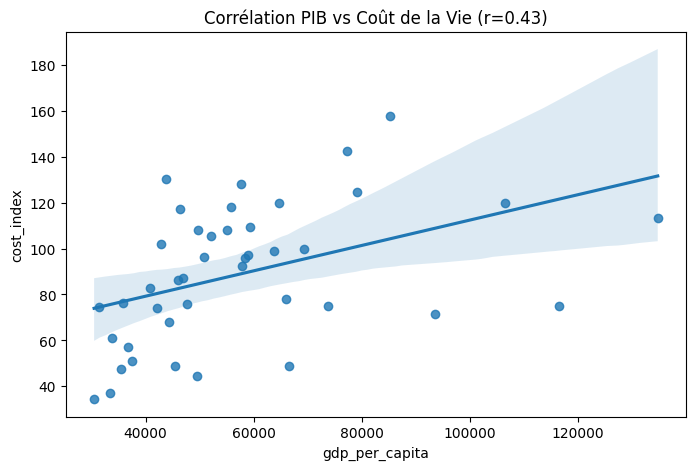

In [26]:

correlation = merged_df['gdp_per_capita'].corr(merged_df['cost_index'])
print(f"Corrélation entre PIB et Coût de la Vie : {correlation:.2f}")

# Visualisation de la corrélation
plt.figure(figsize=(8, 5))
sns.regplot(data=merged_df, x='gdp_per_capita', y='cost_index')
plt.title(f"Corrélation PIB vs Coût de la Vie (r={correlation:.2f})")
plt.show()


Le coefficient de corrélation est de 0.43, ce qui indique une corrélation modérée et positive. Ceci montre que la richesse nationale n'est pas le seul déterminant du coût de la vie.

En général, une augmentation du PIB par habitant est associée à une augmentation du coût de la vie, mais ce n'est pas systématique.

Il existe plusieurs points éloignés de la ligne de régression, suggérant des exceptions ou des facteurs externes.

### Formule écart type

\begin{equation}
  \sigma = \sqrt{\frac{1}{N}\sum_{i = 1} ^N(x_i-\mu)}
\end{equation}


Pays atypiques (PIB élevé mais coût faible ou inversement) :
     country  gdp_per_capita  cost_index
1  Singapore          116486        75.0


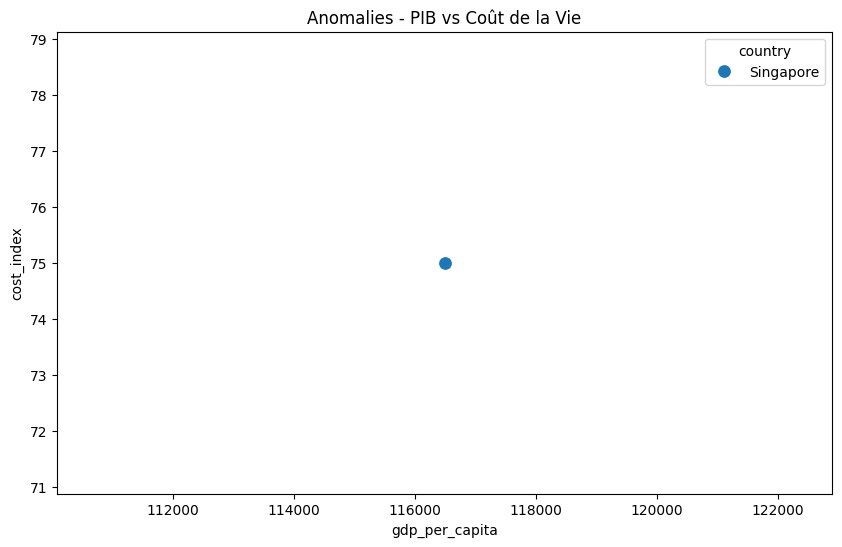

In [27]:
mean_gdp = merged_df['gdp_per_capita'].mean()
std_gdp = merged_df['gdp_per_capita'].std()
mean_cost = merged_df['cost_index'].mean()
std_cost = merged_df['cost_index'].std()

# Détection des anomalies
anomalies = merged_df[
    ((merged_df['gdp_per_capita'] > mean_gdp + 2 * std_gdp) & (merged_df['cost_index'] < mean_cost)) |
    ((merged_df['gdp_per_capita'] < mean_gdp) & (merged_df['cost_index'] > mean_cost + 2 * std_cost))
]

# Affichage des anomalies
print("Pays atypiques (PIB élevé mais coût faible ou inversement) :")
print(anomalies[['country', 'gdp_per_capita', 'cost_index']])

# Visualisation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=anomalies, x='gdp_per_capita', y='cost_index', hue='country', s=100)
plt.title("Anomalies - PIB vs Coût de la Vie")
plt.show()


Une anomalie est détectée pour Singapour.

Singapour a un PIB par habitant très élevé mais un coût de la vie relativement faible par rapport aux autres pays avec un PIB similaire.

Cela pourrait s'expliquer par des politiques gouvernementales spécifiques ou une économie très ouverte qui réduit certains coûts. Mais aussi, le fait que la ville soit connu pour son rôle de hub financier et commercial, ce qui pourrait compenser le coût de la vie.

## Conclusion  

 La corrélation positive modérée (r=0.43) entre le PIB par habitant et l'indice du coût de la vie. Cela signifie que les pays les plus riches ont tendance à avoir un coût de la vie plus élevé, mais ce n'est pas une règle systématique. Nous avons le cas du Luxembourg qui affiche un PIB élevé et éegalement un coût de la vie parmi les plus important.

À l'inverse de Singapour, qui est un exemple marquant d'un pays avec un PIB très élevé mais un coût de la vie inférieur à la moyenne. Cela peut s'expliquer par des politiques économiques spécifiques et un modèle économique axé sur l'attractivité des investissements étrangers.

Les résultats montrent que le PIB par habitant ne suffit pas à expliquer entièrement le coût de la vie. D'autres facteurs doivent être pris en compte :

Politiques fiscales et sociales : Les pays avec des programmes sociaux étendus ont souvent un coût de la vie plus élevé.

Modèle économique : Les pays financiers ou ayant une forte attractivité économique (comme Singapour) maintiennent des coûts bas pour attirer les talents et les entreprises.

Facteurs géographiques : Les pays insulaires ou avec une faible production locale peuvent voir leurs coûts de la vie augmenter en raison de la dépendance aux importations.




## 2. Analyse de la Corrélation entre Corruption et Chômage
Étudier l'impact de la corruption sur le taux de chômage par pays.

In [38]:
corruption_df = dataframes["corruption.csv"]
unemployment_df = dataframes["unemployment.csv"]

corruption_df = corruption_df.dropna().drop_duplicates()
unemployment_df = unemployment_df.dropna().drop_duplicates()

print("Corruption:")
print(corruption_df.head())
print("\nUnemployment:")
print(unemployment_df.head())


Corruption:
       country  annual_income  corruption_index
0      Denmark          68110                12
1      Finland          53660                12
2  New Zealand          45340                12
3       Norway          84090                15
4    Singapore          64010                15

Unemployment:
            country  unemployment_rate
0  Marshall Islands               36.0
1      South Africa               33.6
2          Kiribati               30.6
3            Kosovo               30.5
4    American Samoa               29.8


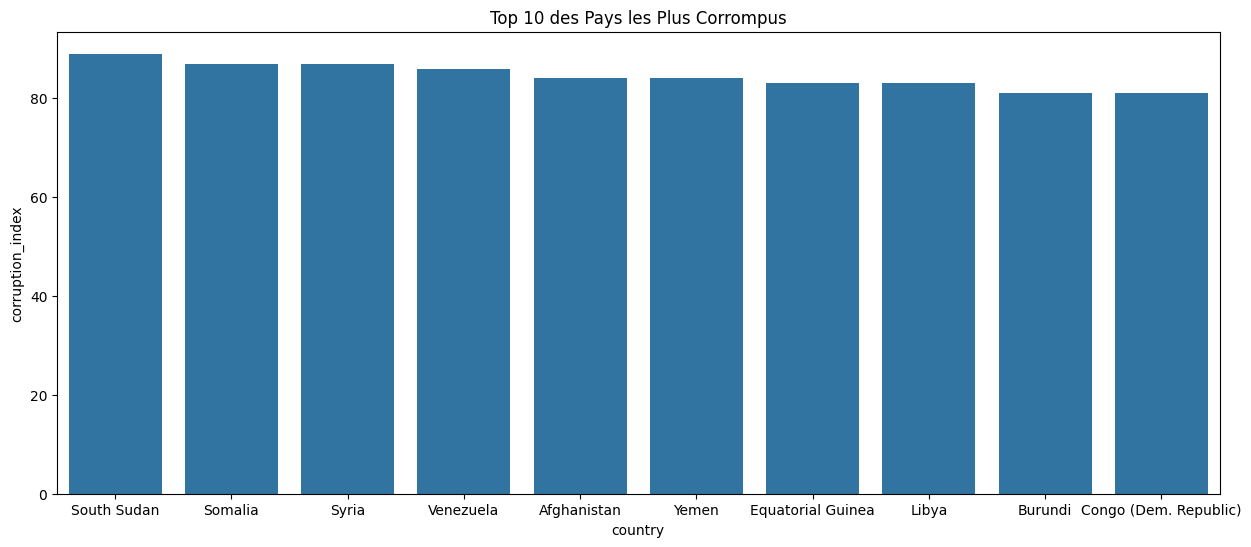

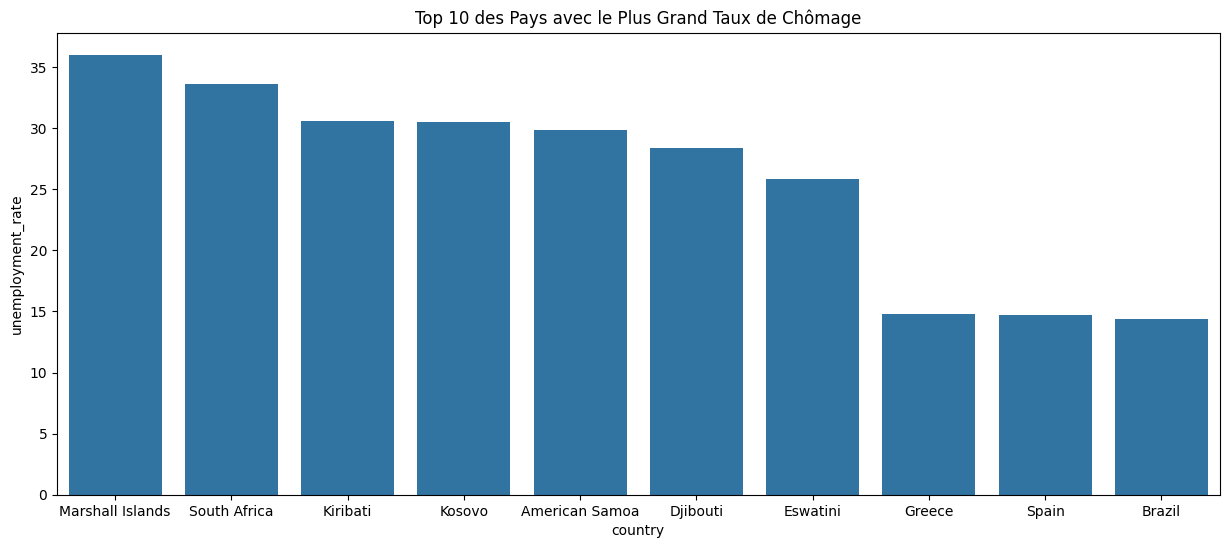

In [66]:
top10_corruption = corruption_df.nlargest(10, 'corruption_index')

plt.figure(figsize=(15, 6))
sns.barplot(data=top10_corruption, x='country', y='corruption_index')
plt.title('Top 10 des Pays les Plus Corrompus')
plt.show()

top10_unemployment = unemployment_df.nlargest(10, 'unemployment_rate')

plt.figure(figsize=(15, 6))
sns.barplot(data=top10_unemployment, x='country', y='unemployment_rate')
plt.title('Top 10 des Pays avec le Plus Grand Taux de Chômage')
plt.show()

Les pays les plus corrompus sont principalement des états en conflit ou instables comme le Soudan du Sud, la Somalie et la Syrie.

Les pays d'Afrique, du Moyen-Orient et d'Amérique latine sont surreprésentés dans cette liste.

On peut croire que la corruption extrême est souvent liée à des conflits internes, des gouvernements fragiles ou des problèmes économiques graves, ou ce sont des pays qui souffrent souvent de mauvaise gouvernance et d'instabilité politique.

Les îles et petits états ont souvent des économies peu diversifiées, ce qui rend l'emploi instable. Les pays européens comme Grèce et Espagne sont également présents, indiquant des difficultés économiques persistantes.

Les pays d'Afrique subsaharienne souffrent également d'un chômage structurel élevé dû à la croissance démographique rapide et au manque d'industrialisation.

Les pays européens comme la Grèce subissent encore les effets de la crise économique passée.

In [46]:
merged_df = pd.merge(corruption_df, unemployment_df, on='country')

print("Colonnes :", merged_df.columns)
print("\nValeurs manquantes :")
print(merged_df.isnull().sum())
print(merged_df.head())


Colonnes : Index(['country', 'annual_income', 'corruption_index', 'unemployment_rate'], dtype='object')

Valeurs manquantes :
country              0
annual_income        0
corruption_index     0
unemployment_rate    0
dtype: int64
       country  annual_income  corruption_index  unemployment_rate
0      Denmark          68110                12                4.8
1       Norway          84090                15                5.0
2    Singapore          64010                15                3.6
3       Sweden          58890                15                8.7
4  Switzerland          90360                16                5.3


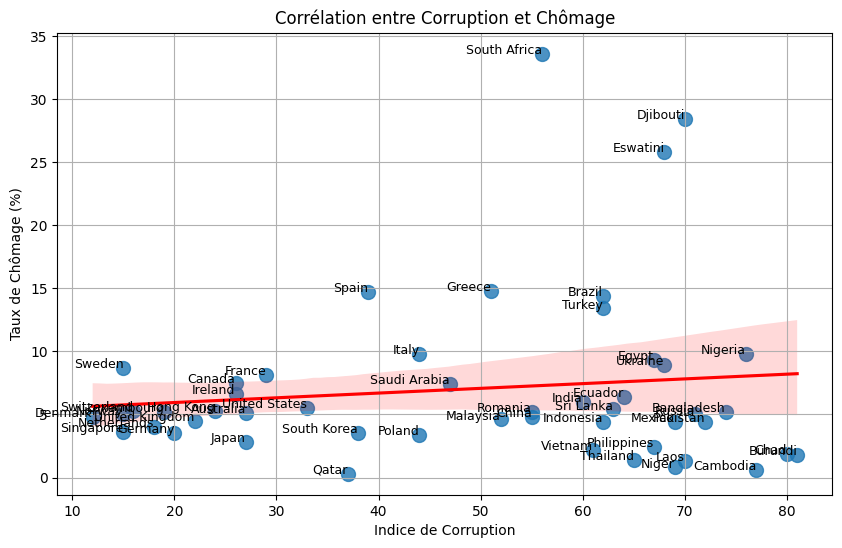

In [51]:

plt.figure(figsize=(10, 6))

#régression linéaire
sns.regplot(data=merged_df, x="corruption_index", y="unemployment_rate",
            scatter_kws={"s": 100}, line_kws={"color": "red"}, marker="o")

for i in range(merged_df.shape[0]):
    plt.text(merged_df["corruption_index"][i], merged_df["unemployment_rate"][i],
             merged_df["country"][i], fontsize=9, ha='right')

plt.title("Corrélation entre Corruption et Chômage")
plt.xlabel("Indice de Corruption")
plt.ylabel("Taux de Chômage (%)")
plt.grid(True)
plt.show()


In [53]:
correlation = merged_df["corruption_index"].corr(merged_df["unemployment_rate"])
print(f"Coefficient de corrélation entre la corruption et le chômage : {correlation:.2f}")


Coefficient de corrélation entre la corruption et le chômage : 0.12


Ce graphique représente la corrélation entre l'indice de corruption (en abscisse) et le taux de chômage (en ordonnée) pour différents pays. Une ligne de régression linéaire (en rouge) montre la tendance générale.

La corrélation est positive mais faible (0.12) suggèrant que l'indice de corruption n'est pas le facteur principal du taux de chômage.

Certains pays comme Afrique du Sud, Djibouti, et Eswatini présentent un taux de chômage élevé malgré une corruption modérée.

Les pays avec une faible corruption, tels que Suède, Singapour et Allemagne, ont également un faible taux de chômage.

Des pays comme Nigeria et Égypte montrent à la fois un indice de corruption élevé et un chômage élevé.

On retrouve les pays développés avec de bonnes institutions se retrouvent souvent dans le quadrant inférieur gauche (faible corruption et faible chômage).

La normalisation pour éviter que les variables avec de grandes valeurs influencent le clustering.

In [56]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_df[['corruption_index', 'unemployment_rate']])
data_scaled = pd.DataFrame(scaled_data, columns=['corruption_index', 'unemployment_rate'])
print("Données normalisées :")
print(data_scaled.head())

Données normalisées :
   corruption_index  unemployment_rate
0         -1.721356          -0.335255
1         -1.581028          -0.305107
2         -1.581028          -0.516149
3         -1.581028           0.252647
4         -1.534252          -0.259883


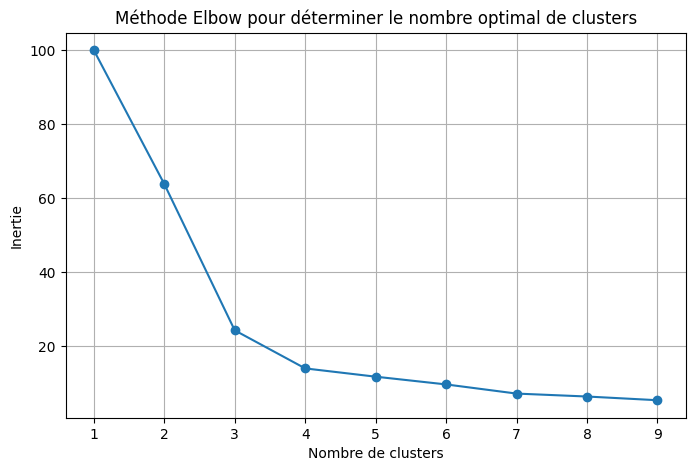

In [67]:
# Calculer l'inertie pour différents nombres de clusters
inertias = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertias.append(kmeans.inertia_)

# Tracer la courbe Elbow
plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), inertias, marker='o')
plt.title("Méthode Elbow pour déterminer le nombre optimal de clusters")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.grid(True)
plt.show()


La cassure (elbow) apparaît au nombre de clusters = 3. Donc le choix de 3 clusters est optimal, car il équilibre la compacité intra-cluster et l'efficacité de la segmentation.



In [70]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_scaled)
merged_df['Cluster'] = clusters

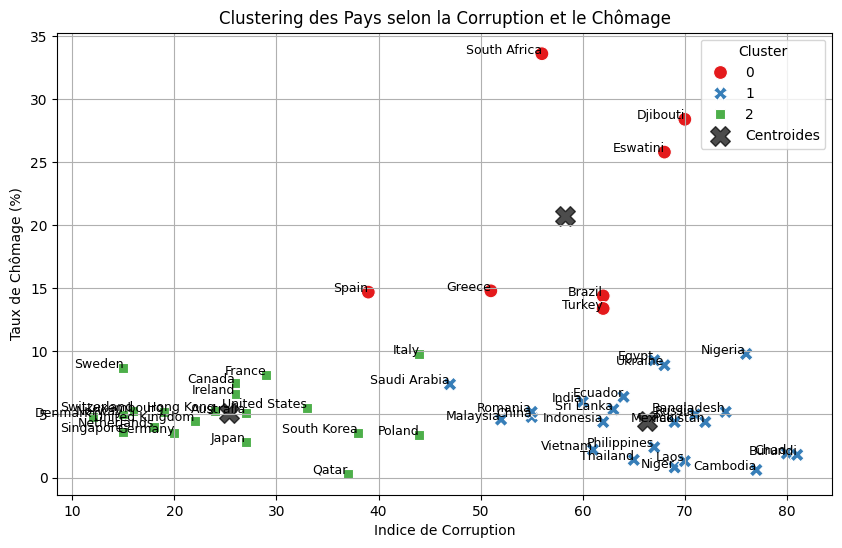

In [71]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x="corruption_index", y="unemployment_rate",
                hue="Cluster", palette="Set1", s=100, style="Cluster")

# Ajouter les centres des clusters
centers = kmeans.cluster_centers_ * scaler.scale_ + scaler.mean_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.7, marker='X', label="Centroides")

# Ajouter les noms des pays
for i in range(merged_df.shape[0]):
    plt.text(merged_df["corruption_index"][i], merged_df["unemployment_rate"][i],
             merged_df["country"][i], fontsize=9, ha='right')

plt.title("Clustering des Pays selon la Corruption et le Chômage")
plt.xlabel("Indice de Corruption")
plt.ylabel("Taux de Chômage (%)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


### Analyse des clusters :

1.  Cluster rouge : Pays avec Corruption Modérée à Élevée et Chômage Moyen à Élevé

Pays : Afrique du Sud, Grèce, Espagne,Brésil, Turquie, Eswatini, Djibouti

Caractéristiques :

Chômage moyen à élevé (10% à 35%)

Corruption modérée à élevée (40 à 70)


Ces pays sont des économies émergentes ou des économies en crise.

2.  Cluster bleu : Pays avec Corruption Élevée mais Chômage Faible à Modéré


Pays : Nigéria, Égypte, Bangladesh, Philippines, Vietnam, Mexique, Thaïlande

Caractéristiques :

Chômage faible à moyen (0% à 10%)

Corruption élevée (50 à 80)

Ces pays sont souvent des économies en développement. Bien que ces pays aient une corruption élevée, ils ne souffrent pas systématiquement de chômage massif. Cela peut être dû à une économie informelle très développée ou à des politiques économiques spécifiques.

3. Cluster vert : Pays avec Faible Corruption et Faible Chômage

Pays : Suède, Canada, Allemagne, Japon, Suisse, Royaume-Uni, Singapour

Caractéristiques :

Chômage faible (0% à 10%)

Corruption faible à modérée (10 à 40)

Les pays de ce cluster ont des politiques de lutte contre la corruption efficaces, ce qui contribue à un climat économique sain.



## Conclusion



*   La corrélation entre corruption et chômage n'est pas systématique. Certains pays comme ceux du cluster bleu montrent une forte corruption mais un faible chômage.


*   Pays Atypiques :

  * Afrique du Sud est un cas particulier avec un chômage extrême malgré une corruption modérée.
  
  * Nigéria montre une forte corruption mais un chômage relativement bas.

*  Insight

 * Les économies avancées (cluster vert) montrent que des institutions solides et une transparence accrue favorisent la stabilité économique.

 * Les pays émergents et ceux en crise économique (clusters rouge et bleu) montrent que la corruption élevée peut coexister avec des taux de chômage très variés.

*  Limites :    
  * Les données de chômage peuvent être biaisées dans certains pays en raison de secteurs informels importants ou de données incomplètes.

  * Les pays insulaires ou territoires spécifiques peuvent fausser les résultats.


## 3. Analyse du Tourisme et de la Richesse
Vérifier si les pays les plus riches attirent également le plus de touristes.

## 4. Indice de Développement Humain : Corrélation entre PIB, Tourisme et Chômage
Analyser l'impact combiné du PIB, du tourisme et du chômage sur le développement humain.

## 5. Classement des Pays par Qualité de Vie
Créer un indice composite de la qualité de vie en combinant le coût de la vie, la corruption et le taux de chômage.

## 6. Analyse de l'Attractivité Touristique en fonction de la Richesse
 Identifier les pays les plus attractifs pour les touristes en tenant compte de la richesse et du coût de la vie